<a href="https://colab.research.google.com/github/AntonioLunardi/Loan-Classification-Prediction-Competition-Case/blob/main/Bank_loan_classification_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Preconfiguration

In [208]:
# Make installations
# !pip install graphviz==0.9
# !pt-get install graphviz

In [209]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew 
from pandas import get_dummies

In [210]:
# ML libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

In [211]:
# Avoid generating warning messages
import warnings
warnings.filterwarnings("ignore") 

# Styles
theme = sns.set_theme(style='whitegrid')
colors = sns.color_palette('pastel')

# Standardize random parameters for obtaining constant results
SEED = 452

# 1.0 EDA (Exploratory data analysis)

## 1.1 Data overview

In [212]:
# Read the dataframe
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [213]:
df_test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [214]:
# Check the number of columns and rows
df_train.shape

(614, 13)

In [215]:
df_train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


This is appearently a cleaned and ordered data frame. Although it is necessary to do tests to check if all registers are consistent

In [216]:
df_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

The index column is already present

## 1.2 Numerical data summary

In [217]:
# Describe statistically
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [218]:
df_train.describe(include = ['object'])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


The data frame doesn't have any duplicated register of loan

## 1.3 Categorial and numerical features discrimination

In [219]:
# Separe columns in two types to ease the analysis

categorical_cols = df_train.dtypes == 'object'
categorical_cols = list(categorical_cols[categorical_cols].index)
categorical_cols.remove('Loan_ID') # Not useful as a category
categorical_cols.remove('Loan_Status') # Target variable

numeric_cols = df_train.dtypes != 'object'
numeric_cols = list(numeric_cols[numeric_cols].index) 

In [220]:
numeric_cols

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [221]:
categorical_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

## 1.4 Visualization

### 1.4.1 Loan status (target)

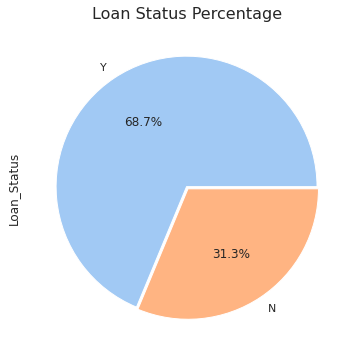

In [222]:
# Pie chart
df_train['Loan_Status'].value_counts().plot\
  .pie(autopct = '%1.1f%%',figsize =(6, 6),explode=(0.01,0.01),colors=colors)\
  .set_title('Loan Status Percentage').set_fontsize('16')

### 1.4.2 Loan status and numerical features 

In [223]:
# Separe target from train data frame
target_train = df_train['Loan_Status']

In [224]:
def boxplot(column, target, train, max_y, title=''):
  f, ax = plt.subplots(figsize=(8, 6))
  fig = sns.boxplot(x=target, y=column, data=train)
  fig.set_title(title).set_fontsize('16')
  fig.axis(ymin = 0, ymax = max_y)

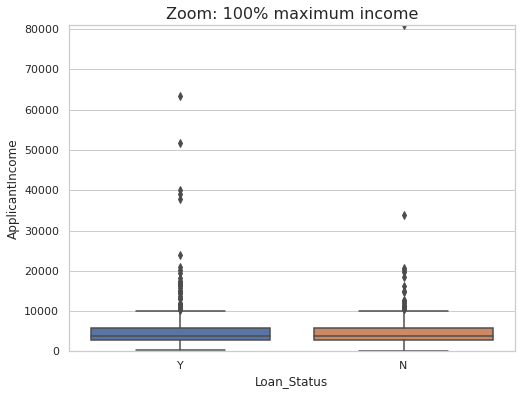

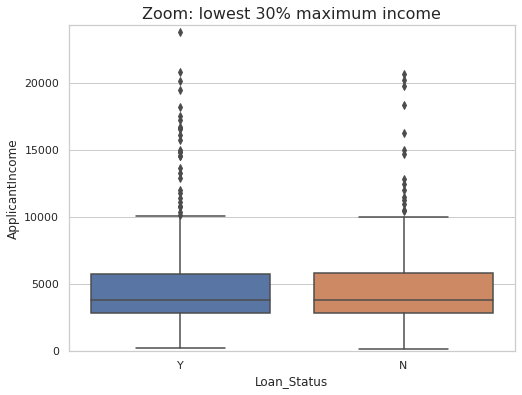

In [225]:
# Applicant income

boxplot(column=numeric_cols[0], target=target_train,\
        train=df_train, max_y=1.0*max(df_train[numeric_cols[0]]),\
        title='Zoom: 100% maximum income')

boxplot(column=numeric_cols[0], target=target_train,\
        train=df_train, max_y=0.3*max(df_train[numeric_cols[0]]),\
        title='Zoom: lowest 30% maximum income')

As it can be seen in the figure above, there is a high quantity of outlayers. The categorires of loan status have simililar distributions and medians.

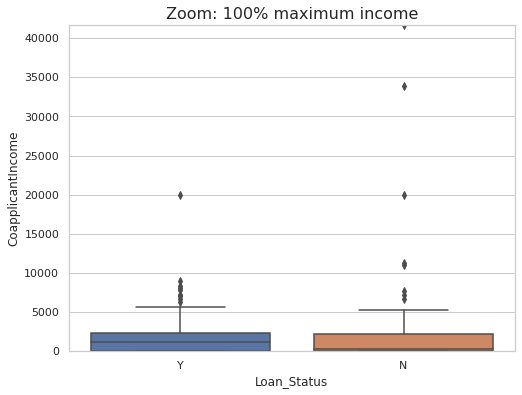

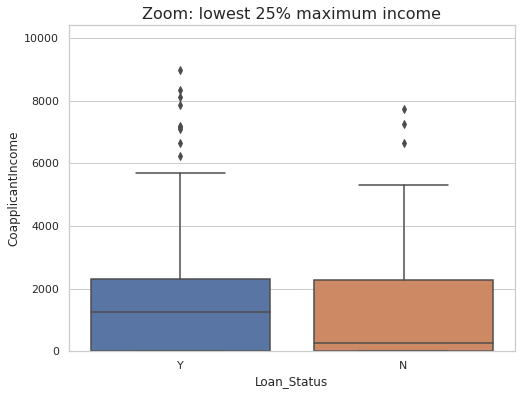

In [226]:
# Coapplicant income

boxplot(column=numeric_cols[1],\
        target=target_train,\
        train=df_train,\
        max_y=1.0*max(df_train[numeric_cols[1]]),\
        title='Zoom: 100% maximum income')

boxplot(column=numeric_cols[1],\
        target=target_train,\
        train=df_train,\
        max_y=0.25*max(df_train[numeric_cols[1]]),\
        title='Zoom: lowest 25% maximum income')

Although the distributions are similar, the refused loans distribuition has a smaller median than the accepted one. It indicates that a half of the denied loans is located in the very narrow space under the line, being this variable zero or almost it.

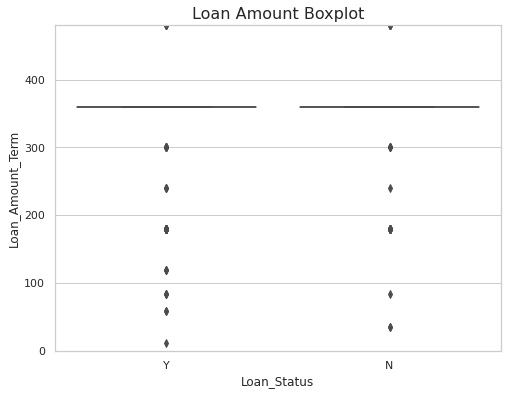

In [227]:
# Loan amount terms
boxplot(column=numeric_cols[3],\
        target=target_train,\
        train=df_train,\
        max_y=max(df_train[numeric_cols[3]]),\
        title='Loan Amount Boxplot')

With only a few outliers, the vast majority of the amount terms are condensed on the line that represents a bit less than 400 dolars.

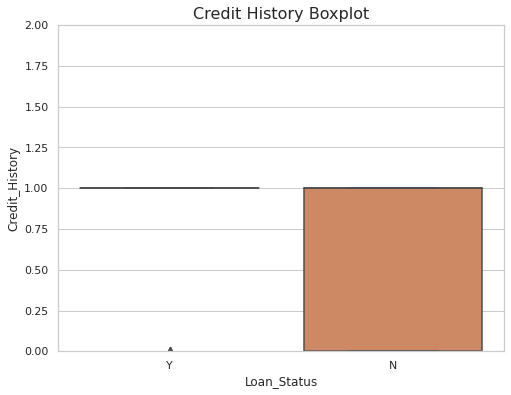

In [228]:
# Loan amount terms
boxplot(column=numeric_cols[4],\
        target=target_train,\
        train=df_train,\
        max_y=2*max(df_train[numeric_cols[4]]),\
        title='Credit History Boxplot')

Very different behaviors. Almost all accepted loans in 1.0, while denied ones are very disperse, but also most frequently in 1.0, when it is analysed carefully. The disaproved loans samples have more variaty of credit history.

In [229]:
# Average of numerical features in ACCEPTED loans
round(df_train[df_train['Loan_Status'] == 'Y'].mean())

ApplicantIncome      5384.0
CoapplicantIncome    1505.0
LoanAmount            144.0
Loan_Amount_Term      341.0
Credit_History          1.0
dtype: float64

In [230]:
# Average of numerical features in NOT ACCETPTED loans
round(df_train[df_train['Loan_Status'] == 'N'].mean())

ApplicantIncome      5446.0
CoapplicantIncome    1878.0
LoanAmount            151.0
Loan_Amount_Term      344.0
Credit_History          1.0
dtype: float64

In [231]:
df_train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [232]:
encoder = LabelEncoder()
df_train['Loan_Status'] = encoder.fit_transform(df_train['Loan_Status']) # Convert to numeric for barplotting

### 1.4.3 Loan status and categorical features

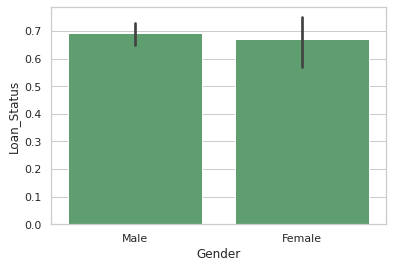

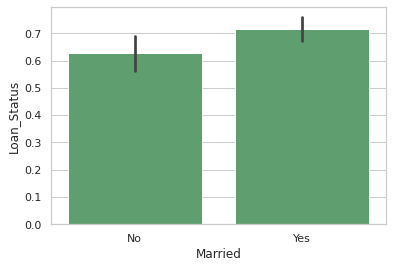

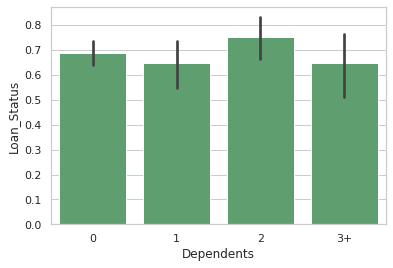

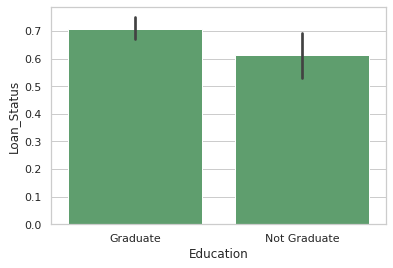

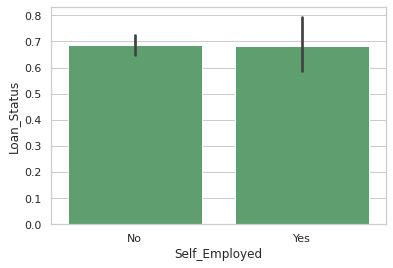

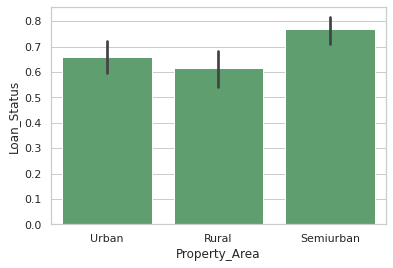

In [233]:
# Autoplot categoricals
for column in categorical_cols:
  sns.barplot(data=df_train, x=column, y='Loan_Status', color='g')
  plt.show()

# 2.0 Data cleaning and preparation

## 2.1 Adjusting data types

In [234]:
# Treat missing data of the full data frame
df_complete = pd.concat([df_train],axis = 0)

# Save the id column of the test data frame
y =  df_complete['Loan_Status']

In [235]:
# Check df variable types
df_complete.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status            int64
dtype: object

In [236]:
# Change 'CoapplicantIncome' type to stablish a standard in data
df_complete['ApplicantIncome'] = df_train['ApplicantIncome'].astype(float)
df_complete['ApplicantIncome'].dtypes

dtype('float64')

## 2.2 Missing values overview

In [237]:
# Drop the target column
df_relevant_columns = df_complete.drop(['Loan_Status', 'Loan_ID'], axis = 1)
df_relevant_columns.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban


In [238]:
# Function to organize in a table all columns with missing data grouped by columns
def missing_values_df(df):
    quantity_missing_values_df = df.isnull().sum().sort_values(ascending=False)
    percentage_missing_values_df = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    percentage_missing_values_df = round(percentage_missing_values_df, 2)
    missing_data_df = pd.concat([quantity_missing_values_df, percentage_missing_values_df], axis=1, keys=['Missing values', 'Percentage'])
    return missing_data_df

In [239]:
# Columns with missing values
missing_data = missing_values_df(df_relevant_columns)
missing_data[missing_data['Missing values'] > 0]

,Missing values,Percentage
Credit_History,50,8.14
Self_Employed,32,5.21
LoanAmount,22,3.58
Dependents,15,2.44
Loan_Amount_Term,14,2.28
Gender,13,2.12
Married,3,0.49


## 2.3 Missing values fulfillment

In [240]:
# Credit history
df_relevant_columns['Credit_History'] = df_relevant_columns['Credit_History'].fillna(-1)

The value -1 is a good marker because it clearly differs from this positive classification.

In [241]:
# Self employed
df_relevant_columns['Self_Employed'] = df_relevant_columns['Self_Employed'].fillna('Other')

The lack of information can be due to the fact that there can be job situations that do not fit well in this binary classification. For instance, cases like retirement, unemployment or not being in labor force.

In [242]:
# Remaining columns
numerical_remaining_columns = ['LoanAmount', 'Loan_Amount_Term']
categorical_remaining_columns = ['Gender', 'Married','Dependents']

In [243]:
# Create a general median filling fuction
median_inputer = SimpleImputer(strategy='median')

for column in numerical_remaining_columns:
    df_relevant_columns[column] = pd.DataFrame(median_inputer.fit_transform(pd.DataFrame(df_relevant_columns[column])))

In [244]:
# Create a general median filling fuction
most_frequent_inputer = SimpleImputer(strategy='most_frequent')

for column in categorical_remaining_columns:
    df_relevant_columns[column] = pd.DataFrame(most_frequent_inputer.fit_transform(pd.DataFrame(df_relevant_columns[column])))

In [245]:
# Check number of NaNs
df_relevant_columns.apply(lambda x: x.isna().value_counts())

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
False,614,614,614,614,614,614,614,614,614,614,614


All nans were successfully fulfilled

## 2.4 Correlation analysis

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

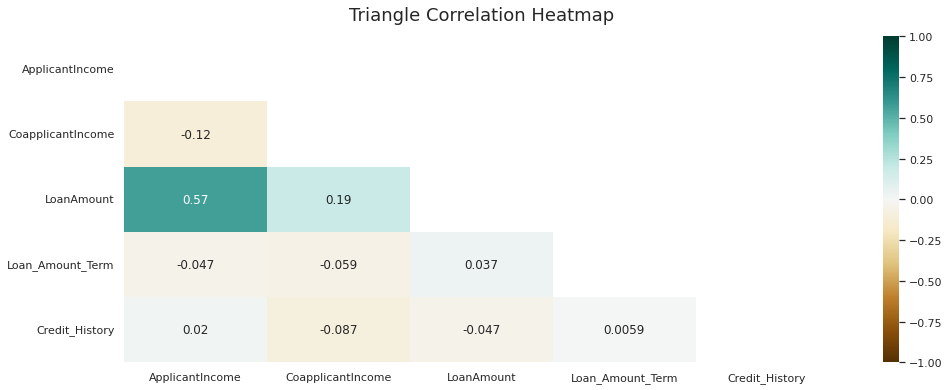

In [246]:
# Graphic plotation
# Upper triangle was hidden in order to ease the visualization, because it has the same values from the lower one
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_relevant_columns.corr(), dtype=np.bool)) # Defining the mask to set the values in the upper triangle to True
heatmap = sns.heatmap(df_relevant_columns.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16) 

As can be observed in the figure above, there are no variables that present a high correlation with each other.

## 2.5 Feature engineering

In [247]:
# Create 'Total_Income' column
df_relevant_columns['Total_Income'] = df_relevant_columns['ApplicantIncome'] + df_relevant_columns['CoapplicantIncome']
df_relevant_columns = df_relevant_columns.drop(columns=['ApplicantIncome', 'CoapplicantIncome'])

Creating 'Total_income' by summing 'ApplicantIncome' and 'CoapplicantIncome' and dropping them

In [248]:
df_relevant_columns = df_relevant_columns.replace({'Dependents': r'3+'}, {'Dependents': 4}, regex=True)

Convert 3+ category into 4 (also making it numerical)

In [249]:
# Apply LabelEncoder to categorical features
le = LabelEncoder()
le.fit(list(df_relevant_columns["Dependents"].values))
df_relevant_columns["Dependents"] = le.transform(list(df_relevant_columns["Dependents"].values))
print('Shape all_data: {}'.format(df_relevant_columns.shape))

Shape all_data: (614, 10)


## 2.6 Categorical columns dummyzation 

In [250]:
df_dummies = pd.get_dummies(df_relevant_columns)
df_dummies.head(3)

,Dependents,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Other,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,128.0,360.0,1.0,5849.0,0,1,1,0,1,0,1,0,0,0,0,1
1,1,128.0,360.0,1.0,6091.0,0,1,0,1,1,0,1,0,0,1,0,0
2,0,66.0,360.0,1.0,3000.0,0,1,0,1,1,0,0,0,1,0,0,1


## 2.7 Train and test data frames

In [251]:
x_train, x_test, y_train, y_test = train_test_split(df_dummies, y, test_size=0.3, random_state=SEED)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((429, 17), (185, 17), (429,), (185,))

# 3.0 Machine learning models

## 3.1 Simple models

In [252]:
# Dummy classifier

dummy = DummyClassifier(random_state=SEED)
dummy.fit(x_train,y_train)
y_pred = dummy.predict(x_test)
acc_dummy = round(accuracy_score(y_test,y_pred)*100,2)

In [253]:
# Logistic regression

logreg = LogisticRegression(random_state=SEED)
logreg.fit(x_train,y_train)
y_pred = logreg.predict(x_test)
acc_log = round(accuracy_score(y_test,y_pred)*100,2)

In [254]:
# Support vector classifier

svc = SVC(random_state=SEED)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
acc_svc  = round(accuracy_score(y_test,y_pred)*100,2)

In [255]:
# K-neighbors classifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc_knn = round(accuracy_score(y_test,y_pred)*100,2)

In [256]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_test)
acc_gaussian = round(accuracy_score(y_test,y_pred)*100,2)

In [257]:
# Perceptron

perceptron = Perceptron(random_state=SEED)
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_test)
acc_perceptron = round(accuracy_score(y_test,y_pred)*100,2)

In [258]:
# Decision Tree classifier

decision_tree = DecisionTreeClassifier(random_state=SEED)
decision_tree.fit(x_train, y_train)
y_pred = decision_tree.predict(x_test)
acc_decision_tree = round(accuracy_score(y_test,y_pred)*100,2)

In [259]:
# Random Forest classifier

random_forest = RandomForestClassifier(random_state = SEED)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
acc_random_forest = round(accuracy_score(y_test,y_pred)*100,2)

In [260]:
# Gradient boosting classifier

gbc = GradientBoostingClassifier(random_state=SEED)
gbc.fit(x_train, y_train)
y_pred = gbc.predict(x_test)
acc_gbc = round(accuracy_score(y_test,y_pred)*100,2)

In [261]:
# Light gradient boosting machine classifier

lgbmc = lgb.LGBMClassifier(random_state=SEED)
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_test)
acc_lgbmc = round(accuracy_score(y_test,y_pred)*100,2)

In [262]:
# X gradient boosting classifier

xgbc = XGBClassifier(random_state=SEED)
xgbc.fit(x_train, y_train)
y_pred = xgbc.predict(x_test)
acc_xgbc = round(accuracy_score(y_test,y_pred)*100,2)

In [263]:
models = pd.DataFrame({
    'Model': ['Dummy classifier','Support vector classifier', 'K-neighbors classifier', 'Logistic regressor', 
              'Random forest classifier', 'Gaussian Naive-Bayes', 'Perceptron',  
              'Decision tree classifier', 'Gradient boosting classifier', 'XGBClassifier', 'LGBMClassifier'],
              
    'RMSE': [acc_dummy, acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_decision_tree, acc_gbc, acc_xgbc, acc_lgbmc]})
models.sort_values(by='RMSE', ascending=False)

,Model,RMSE
4,Random forest classifier,80.00
8,Gradient boosting classifier,80.00
10,LGBMClassifier,79.46
3,Logistic regressor,77.30
9,XGBClassifier,77.30
0,Dummy classifier,74.59
7,Decision tree classifier,74.59
1,Support vector classifier,74.05
5,Gaussian Naive-Bayes,74.05
6,Perceptron,56.76


## 3.2 Cross-validated models

In [264]:
# Calculate root mean square error
def rmse_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    rmse = (cross_val_score(model, x_test,
                                   y_test, scoring='f1', cv = cv))
    return(rmse)

In [265]:
# Dummy classifier
dummy_score = rmse_cv(dummy)

In [266]:
# Support vector classifier
svc_score = rmse_cv(svc)

In [267]:
# Logistic regressor
logreg_score = rmse_cv(logreg)

In [268]:
# K-neighbors classifier
knn_score = rmse_cv(knn)

In [269]:
# Gaussian Naive-Bayes
gaussian_score = rmse_cv(gaussian)

In [270]:
# Decision tree classifier
decision_tree_score = rmse_cv(decision_tree)

In [271]:
# Random forest classifier
random_forest_score = rmse_cv(random_forest)

In [272]:
# Gradient boosting classifier
gbc_score = rmse_cv(gbc)

In [273]:
# X boosting gradient classifier
xgbc_score = rmse_cv(xgbc)

In [274]:
# Light gradient boosting machine classifier
lgbmc_score = rmse_cv(lgbmc)

In [275]:
# Perceptron
perceptron_score = rmse_cv(perceptron)

In [276]:
models = pd.DataFrame({
    'Model': ['Dummy classifier', 'Support vector classifier', 'K-neighbors classifier', 'Logistic regressor', 
              'Random forest classifier', 'Gaussian Naive-Bayes', 'Perceptron',  
              'Decision tree classifier', 'Gradient boosting classifier', 'XGBClassifier', 'LGBMCClassifier'],

    'Accuracy': [dummy_score.mean(), svc_score.mean(), knn_score.mean(), logreg_score.mean(), 
              random_forest_score.mean(), gaussian_score.mean(), perceptron_score.mean(), 
              decision_tree_score.mean(), gbc_score.mean(), xgbc_score.mean(), lgbmc_score.mean()],
    
    'Standard_deviation': [dummy_score.std(), svc_score.std(), knn_score.std(), logreg_score.std(), 
              random_forest_score.std(), gaussian_score.std(), perceptron_score.std(), 
              decision_tree_score.std(), gbc_score.std(), xgbc_score.std(), lgbmc_score.std()]})

models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Standard_deviation
8,Gradient boosting classifier,0.880498,0.053142
7,Decision tree classifier,0.870118,0.028097
4,Random forest classifier,0.865857,0.049547
0,Dummy classifier,0.853297,0.037423
1,Support vector classifier,0.849847,0.035668
9,XGBClassifier,0.841327,0.046854
10,LGBMCClassifier,0.821934,0.038596
3,Logistic regressor,0.815888,0.045711
5,Gaussian Naive-Bayes,0.793908,0.026536
2,K-neighbors classifier,0.789943,0.042254


## 3.3 Cross-validated models with hiperparameters tuning

In [277]:
# Mean square error with grid search parameters and cross-validation
def rmse_optimised_cv(model, parameters_space):
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    search = GridSearchCV(model, parameters_space, cv = cv)
    search.fit(x_test, y_test)
    rmse = (cross_val_score(search, x_test,
                                   y_test, scoring='f1', cv = cv))
    best_hiper_parameters = search.best_estimator_
    print("Best hiperparameters:\n", best_hiper_parameters)
    return(rmse)

In order not to make executions too slow, in most cases on the following cells, only the best found hyperparameters are shown.

In [278]:
# Dummy classifier

# Hiperparameters grid
parameters_space = {
    'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform']}

dummy_score = rmse_optimised_cv(dummy, parameters_space)

Best hiperparameters:
 DummyClassifier(random_state=452, strategy='most_frequent')


In [279]:
# K-neighbors classifier

parameters_space = {
    'n_neighbors' : [13],
    'weights': ['uniform', 'distance'],
    'algorithm': ['kd_tree']}

knn_score = rmse_optimised_cv(knn, parameters_space)

Best hiperparameters:
 KNeighborsClassifier(algorithm='kd_tree', n_neighbors=13)


In [280]:
# Gradient boosting classifier

parameters_space = {
    'learning_rate' : [1],
    'n_estimators': [1],
    'subsample': [0.5, 1],
    'min_samples_leaf': [1, 5, 10]
    }

gbc_score = rmse_optimised_cv(gbc, parameters_space)

Best hiperparameters:
 GradientBoostingClassifier(learning_rate=1, n_estimators=1, random_state=452,
                           subsample=1)


In [281]:
# Support vector classifier

parameters_space = {
    'C' : [1.0],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr'],
    'random_state': [SEED]
    }


svc_score = rmse_optimised_cv(svc, parameters_space)

Best hiperparameters:
 SVC(decision_function_shape='ovo', gamma='auto', random_state=452)


In [282]:
# Logistic regressor

parameters_space = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter' : [100, 200, 300]
    }

logreg_score = rmse_optimised_cv(logreg, parameters_space)

Best hiperparameters:
 LogisticRegression(random_state=452, solver='sag')


In [283]:
# Gaussian Naive-Bayes

parameters_space = {
    "var_smoothing" : [5e-7, 1e-7, 5e-6]}

gaussian_score = rmse_optimised_cv(gaussian, parameters_space)

Best hiperparameters:
 GaussianNB(var_smoothing=1e-07)


In [292]:
# Decision tree classifier

parameters_space = {
    'max_depth' : [1,2,3],
    'min_samples_split' : [1,2,3],
    'min_samples_leaf' : [1,2,3,4],
    'criterion' : ['gini', 'entropy']}

decision_tree_score = rmse_optimised_cv(decision_tree, parameters_space)

Best hiperparameters:
 DecisionTreeClassifier(max_depth=2, min_samples_leaf=3, random_state=452)


In [285]:
# Random forest classifier

parameters_space = {
    'n_estimators': [10],
    'max_depth' : [2],
    'min_samples_split' : [2],
    'min_samples_leaf' : [1,2,3],
    'criterion' : ['gini', 'entropy']}

random_forest_score = rmse_optimised_cv(random_forest, parameters_space)

Best hiperparameters:
 RandomForestClassifier(max_depth=2, n_estimators=10, random_state=452)


In [286]:
# X boosting gradient classifier

parameters_space = {
    'max_depth': [2],
    'learning_rate' : [1],
    'n_estimators' : [32]}

xgbc_score = rmse_optimised_cv(xgbc, parameters_space)

Best hiperparameters:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=32, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=452, ...)


In [287]:
# Light gradient boosting machine classifier

parameters_space = {
    'learning_rate' : [1],
    'num_leaves' : [10],
    'n_estimators ' : [5],
    'subsample': [1],
    'min_samples_leaf': [1],
    'num_iterations': [1]
    }

lgbmc_score = rmse_optimised_cv(lgbmc, parameters_space)

Best hiperparameters:
 LGBMClassifier(learning_rate=1, min_samples_leaf=1, n_estimators =5,
               num_iterations=1, num_leaves=10, random_state=452, subsample=1)


In [288]:
# Perceptron

parameters_space = {
    'alpha' : [0.0001],
    'max_iter': [1],
    'eta0': [0.0001],
    'n_iter_no_change': [1],
    'random_state': [SEED]
    }

perceptron_score = rmse_optimised_cv(perceptron, parameters_space)

Best hiperparameters:
 Perceptron(eta0=0.0001, max_iter=1, n_iter_no_change=1, random_state=452)


In [289]:
models = pd.DataFrame({
    'Model': ['Dummy classifier', 'Support vector classifier', 'K-neighbors classifier', 'Logistic regressor', 
              'Random forest classifier', 'Gaussian Naive-Bayes', 'Perceptron',  
              'Decision tree classifier', 'Gradient boosting classifier', 'XGBClassifier', 'LGBMClassifier'],

    'Accuracy': [dummy_score.mean(), svc_score.mean(), knn_score.mean(), logreg_score.mean(), 
              random_forest_score.mean(), gaussian_score.mean(), perceptron_score.mean(), 
              decision_tree_score.mean(), gbc_score.mean(), xgbc_score.mean(), lgbmc_score.mean()],
    
    'Standard_deviation': [dummy_score.std(), svc_score.std(), knn_score.std(), logreg_score.std(), 
              random_forest_score.std(), gaussian_score.std(), perceptron_score.std(), 
              decision_tree_score.std(), gbc_score.std(), xgbc_score.std(), lgbmc_score.std()]})

models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Standard_deviation
8,Gradient boosting classifier,0.908527,0.032712
7,Decision tree classifier,0.908271,0.025814
4,Random forest classifier,0.876466,0.048833
9,XGBClassifier,0.873582,0.050462
10,LGBMClassifier,0.867413,0.046710
5,Gaussian Naive-Bayes,0.853766,0.047531
0,Dummy classifier,0.853297,0.037423
3,Logistic regressor,0.853297,0.037423
6,Perceptron,0.853297,0.037423
2,K-neighbors classifier,0.851852,0.040009


As it could be noticed, the models with best accuracy are decision tree classifier and gradient boosting classifier, with a difference of accuracy's RMSE lower than 0.1%. Therefore, the used criterion to choose algorithm is standard deviation. Due to the fact of Decision tree classifier has a stardard deviation not only better than gradient boosting classifier, but the whole set. 

This study came to the conclusion that the best model for being used to predict the customers's loan status is the decision tree classifier. Considering, of course, the best tuning hyperparameters found in the section number 3.3 (training and test section).